# CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils_data.utilities import *
from utils_models.models import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import math

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

D:\Anaconda2\envs\stock\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda2\envs\stock\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda2\envs\stock\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda2\envs\stock\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:5

In [2]:
seq_len = 10 # Number of steps
batch_size = 32   # Batch size
learning_rate = 0.0001
epochs = 10
#n_classes = 3
n_channels = 7

In [3]:
X_train, labels_train, _, _,_= read_stock_data_items_and_transform(data_path="./data_sets/", split = "train", n_dim_feautures = 8, hold_days = seq_len, predict_days = 5, gain_threshold=2.0)
X_test, labels_test, X_test_prices,_,_ = read_stock_data_items_and_transform(data_path="./data_sets/", split="test", n_dim_feautures = 8, hold_days = seq_len, predict_days = 5, gain_threshold=2.0)
print(X_train.shape)
print(labels_train.shape)
print(X_test.shape)
print(X_test_prices.shape)
print(len(labels_train[labels_train==0]))
print(len(labels_train[labels_train==1]))

./data_sets/train
./data_sets/test
(20886, 10, 7)
(20886,)
(256, 10, 7)
(256,)
16270
4616


In [4]:
# Normalize?
shuffle_ix = np.random.permutation(np.arange(len(X_train)))
X_train = X_train[shuffle_ix]
labels_train = labels_train[shuffle_ix]

Train/Validation Split

In [5]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, test_size = 0.1, random_state = 0)
print(X_tr.shape)
print(X_vld.shape)
print(lab_tr.shape)
print(lab_vld.shape)

(18797, 10, 7)
(2089, 10, 7)
(18797,)
(2089,)


One-hot encoding:

In [6]:
n_classes = 2
y_tr = one_hot(lab_tr, n_classes)
y_vld = one_hot(lab_vld, n_classes)
y_test = one_hot(labels_test, n_classes)

### Construct the graph
Placeholders

In [7]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')
    is_training_ = tf.placeholder(tf.bool)

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [8]:
with graph.as_default():
    logits, output = cnn_models(inputs_, is_training_, keep_prob_, n_classes_=n_classes)
    # Cost function and optimizer
    #loss = tf.losses.huber_loss(labels=labels_, predictions=logits, delta=1.0)
    #cost = tf.reduce_mean(loss)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):    
        optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy') 

Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Train the network

In [9]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

pre_acc = 0

reload = False
#reload = True
#tf.set_random_seed(1)
#tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

if (os.path.exists('checkpoints-cnn-max') == False):
    !mkdir checkpoints-cnn-max
    !mkdir checkpoints-cnn

with graph.as_default():
    saver = tf.train.Saver(tf.global_variables(), max_to_keep = 5)
    saver2 = tf.train.Saver(tf.global_variables(), max_to_keep = 1)

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    if reload == True :
        saver.restore(sess, tf.train.latest_checkpoint(r'checkpoints-cnn'))
        print("Model restored...")   

    # Loop over epochs
    for e in range(0, epochs):

        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.15, learning_rate_ : learning_rate, is_training_:True}
            # Loss
            loss, _ , acc, logits_ = sess.run([cost, optimizer, accuracy, logits], feed_dict = feed)
            #if math.isnan(loss) :
            #    print(x)
            train_acc.append(acc)
            train_loss.append(loss)
            #print(y)
            # Print at each 5 iters
            if (e==0 and iteration % 100 == 0):
                print("Epoch: {}/{}".format(e, epochs),"Iteration: {:d}".format(iteration),"Train loss: {:6f}".format(loss),"Train acc: {:.6f}".format(acc))               
            elif (e>0 and iteration % 200 == 0):
                print("Epoch: {}/{}".format(e, epochs),"Iteration: {:d}".format(iteration),"Train loss: {:6f}".format(loss),"Train acc: {:.6f}".format(acc))
            # Compute validation loss at every 10 iterations
            if (iteration%500 == 0):                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, is_training_: False}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                if (e == 0):
                    print("Epoch: {}/{}".format(e, epochs),"Iteration: {:d}".format(iteration), "Validation loss: {:6f}".format(np.mean(val_loss_)),"Validation acc: {:.6f}".format(np.mean(val_acc_)))
                    pre_acc = np.mean(val_acc_)
                elif (e > 0):
                    print("Epoch: {}/{}".format(e, epochs),"Iteration: {:d}".format(iteration), "Validation loss: {:6f}".format(np.mean(val_loss_)),"Validation acc: {:.6f}".format(np.mean(val_acc_)))
                    if np.mean(val_acc_) > pre_acc :
                        print(np.mean(val_acc_))
                        print(pre_acc)
                        pre_acc = np.mean(val_acc_)
                        save_max_acc_path = "checkpoints-cnn-max/stock_bank_"+ str(e) + "_" + str(pre_acc) + ".ckpt"
                        saver2.save(sess, save_max_acc_path) 
                # Store
                validation_acc.append(val_acc_)
                validation_loss.append(val_loss_)
            
            # Iterate 
            iteration += 1
        save_path = "checkpoints-cnn/stock_bank_"+ str(e) +".ckpt"
        saver.save(sess, save_path)


Epoch: 0/10 Iteration: 100 Train loss: 1.351553 Train acc: 0.625000
Epoch: 0/10 Iteration: 200 Train loss: 1.064886 Train acc: 0.562500
Epoch: 0/10 Iteration: 300 Train loss: 0.760108 Train acc: 0.593750
Epoch: 0/10 Iteration: 400 Train loss: 1.125217 Train acc: 0.468750
Epoch: 0/10 Iteration: 500 Train loss: 1.681863 Train acc: 0.593750
Epoch: 0/10 Iteration: 500 Validation loss: 0.585001 Validation acc: 0.779327
Epoch: 1/10 Iteration: 600 Train loss: 0.606256 Train acc: 0.687500
Epoch: 1/10 Iteration: 800 Train loss: 1.343374 Train acc: 0.531250
Epoch: 1/10 Iteration: 1000 Train loss: 0.534806 Train acc: 0.718750
Epoch: 1/10 Iteration: 1000 Validation loss: 0.542050 Validation acc: 0.777404
Epoch: 2/10 Iteration: 1200 Train loss: 0.976916 Train acc: 0.625000
Epoch: 2/10 Iteration: 1400 Train loss: 0.610303 Train acc: 0.656250
Epoch: 2/10 Iteration: 1500 Validation loss: 0.545133 Validation acc: 0.779327
Epoch: 2/10 Iteration: 1600 Train loss: 0.608167 Train acc: 0.656250
Epoch: 3/10 

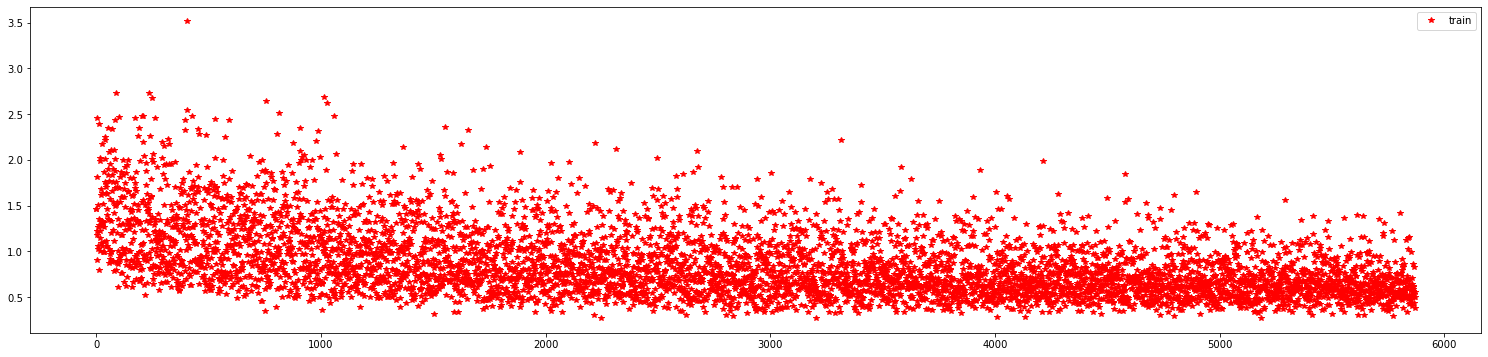

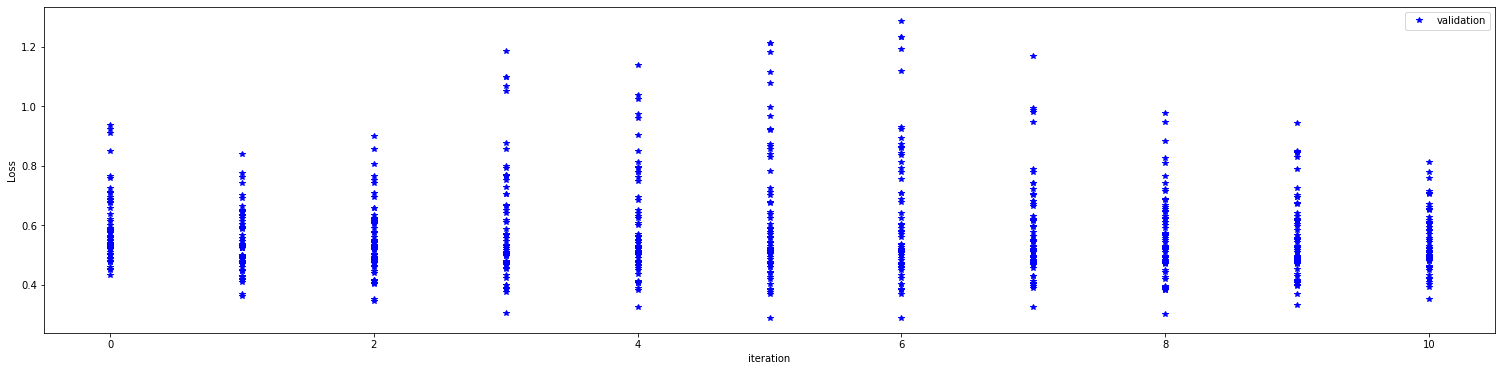

In [10]:
# Plot training and test loss
t = np.arange(len(train_loss))
q = np.arange(len(validation_loss))
plt.figure(figsize = (26,6))
plt.plot(t, np.array(train_loss), 'r*')
plt.legend(['train'], loc='upper right')
plt.figure(figsize = (26,6))
plt.plot(q, np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['validation'], loc='upper right')
plt.show()

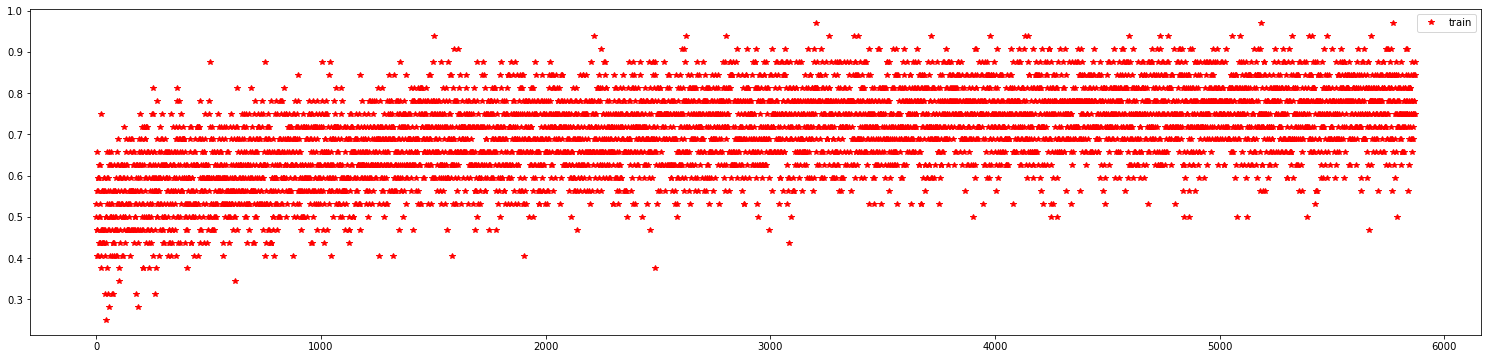

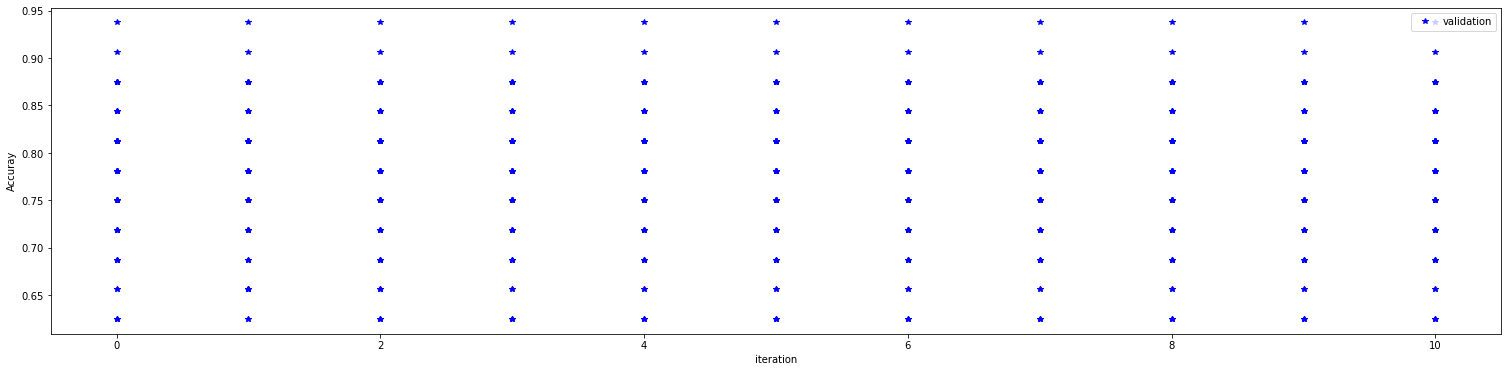

In [11]:
# Plot Accuracies
plt.figure(figsize = (26,6))
plt.plot(t, np.array(train_acc), 'r*')
plt.legend(['train'], loc='upper right')
plt.figure(figsize = (26,6))
plt.plot(q, np.array(validation_acc), 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['validation'], loc='upper right')
plt.show()

## Evaluate on test set

INFO:tensorflow:Restoring parameters from checkpoints-cnn-max\stock_bank_2_0.77355766.ckpt
Test accuracy: 0.703125
Tommorow stock : 
7.8515625


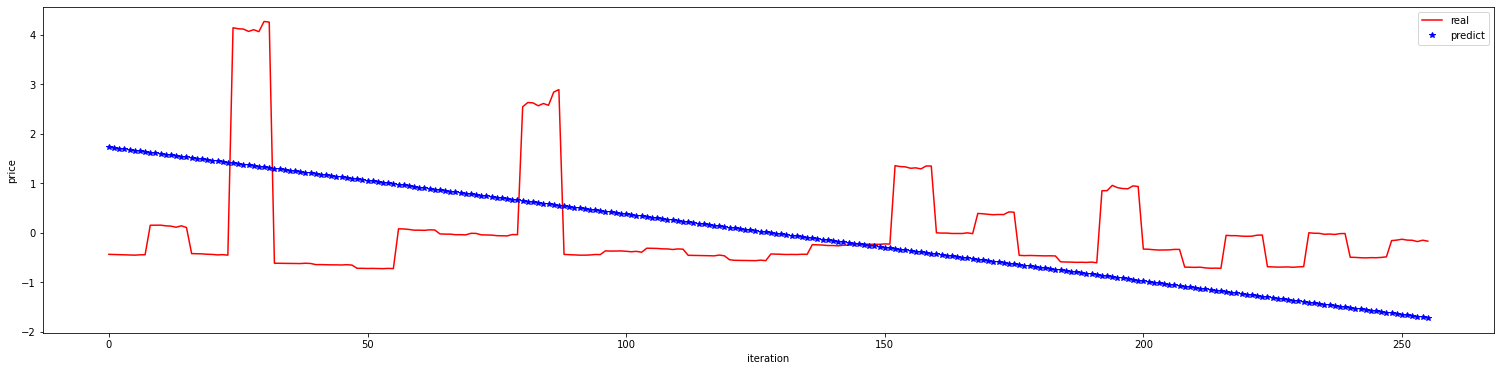

In [12]:
test_acc = []
real_high_prices = []
price = []
predicts = []
predict_count = 0

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn-max'))

    for x_t, y_t, z_t in get_batches_exp(X_test, y_test, X_test_prices, 1):
        #print(y_t)
        feed = {inputs_: x_t, labels_: y_t, keep_prob_: 1.0, is_training_: False}
        batch_acc, logits_  = sess.run([accuracy, logits], feed_dict=feed)
        #print(logits_[0,:])
        sort_list = sorted(range(len(logits_[0,:])), key=lambda k: logits_[0,:][k])
        predict = sort_list[1]
        if predict == 0:
            predict_count += 1
        elif predict == 1:
            predict_count -= 1             
        predicts.append(predict_count)
        real_high_prices.append(z_t[0])
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))      
    
    X_pred,_,_,_,_ = read_stock_data_items_and_transform_by_stock_num(data_path="./data_sets/predict/", stock_code="sh.600000.浦发银行.csv", n_dim_feautures=8, hold_days=10, predict_days=5)
    
    feed = {inputs_: X_pred, keep_prob_: 1, is_training_: False}
    predict_ = sess.run(logits, feed_dict=feed)
    print("Tommorow stock : ")  

    range_ = np.arange(len(predicts))
    # Plot Accuracies
    plt.figure(figsize = (26,6))
    mean_ = np.mean(real_high_prices, axis=0)
    print(mean_)
    std_ = np.std(real_high_prices, axis=0)
    real_high_prices = (real_high_prices - mean_) / std_
    predicts = (predicts - np.mean(predicts, axis=0)) / np.std(predicts, axis=0)
    plt.plot(range_, real_high_prices, 'r-', range_, predicts, 'b*')
    plt.xlabel("iteration")
    plt.ylabel("price")
    plt.legend(['real', 'predict'], loc='upper right')
    plt.show()